In [1]:
import glob
import Levenshtein
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
from difflib import SequenceMatcher
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)

In [25]:
%%time
_df = pd.read_csv('../EVL_updated.csv')

<string>:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.


Wall time: 21.1 s


In [26]:
df = _df.copy()

In [30]:
df['DAT_ODDAJA'].apply(lambda x: x.split('.')[-1]).value_counts()

19    582077
18    567434
17    553952
20    519827
21    324078
Name: DAT_ODDAJA, dtype: int64

In [4]:
df.columns

Index(['MATIČNA_POŠILJATELJA', 'POSILJATELJ', 'STATUS_POSILJATELJA',
       'PREJEMNIK', 'MATIČNA_PREJEMNIKA', 'STATUS_PREJEMNIKA',
       'MATIČNA_PREVOZNIKA', 'PREVOZNIK', 'DAT_ODDAJA', 'KRAJ_ODDAJE',
       'LOKACIJA_ODDAJE', 'DAT_PREJEM_ZAV', 'KRAJ_PREJEMA', 'LOKACIJA_PREJEMA',
       'ŠTEVILKA', 'NAZIV_ODPADKA', 'NEVAREN', 'KOLIČINA ODPADKA v kg',
       'EMB_SHEMA', 'SVEČE PRI ODPADKU 20 02 03 D/N', 'DEJAVNOST_NAST',
       'IZVOR ODPADKA', 'PREDVIDEN POSTOPEK RAVNANJA', 'STATUS_EVL',
       'IND_SPREJETO'],
      dtype='object')

In [10]:
def parse_zip(x):
    for xx in x.split()[::-1]:
        try:
            return int(xx)
        except:
            pass
    return -1

df['ZIP_ODDAJE'] = df['LOKACIJA_ODDAJE'].apply(parse_zip)
df['nXXX_ODDAJE'] = df['ZIP_ODDAJE'].apply(lambda x: x // 1000)
df['ZIP_PREJEMA'] = df['LOKACIJA_PREJEMA'].apply(parse_zip)
df['nXXX_PREJEMA'] = df['ZIP_PREJEMA'].apply(lambda x: x // 1000)

In [11]:
df[['nXXX_ODDAJE', 'ZIP_ODDAJE']].groupby('nXXX_ODDAJE')['ZIP_ODDAJE'].nunique()

nXXX_ODDAJE
-1     1
 1    89
 2    96
 3    63
 4    44
 5    42
 6    36
 8    60
 9    36
Name: ZIP_ODDAJE, dtype: int64

In [12]:
df[['nXXX_PREJEMA', 'ZIP_PREJEMA']].groupby('nXXX_PREJEMA')['ZIP_PREJEMA'].nunique()

nXXX_PREJEMA
-1     1
 1    41
 2    36
 3    25
 4    15
 5    15
 6    11
 8    14
 9    11
Name: ZIP_PREJEMA, dtype: int64

In [13]:
set(df['ZIP_PREJEMA']) - set(df['ZIP_ODDAJE'])

set()

In [14]:
x = df['NAZIV_ODPADKA'].value_counts().reset_index()
x[x['index'].apply(lambda x: 'nevarne' in x.lower())].sort_values('index').values

array([['Agrokemični odpadki, ki vsebujejo nevarne snovi', 230],
       ['Anorganski odpadki, ki vsebujejo nevarne snovi', 676],
       ['Barve, tiskarske barve, lepila in smole, ki vsebujejo nevarne snovi',
        3354],
       ['Barvila in pigmenti, ki vsebujejo nevarne snovi', 15],
       ['Blato iz druge obdelave industrijskih odpadnih voda, ki vsebuje nevarne snovi',
        577],
       ['Blato, ki vsebuje nevarne snovi, iz čiščenja odpadnih voda na kraju nastanka',
        30],
       ['Blato, ki vsebuje nevarne snovi, iz čiščenja odpadnih voda na kraju nastanka snovi',
        14],
       ['Druga sredstva za zaščito lesa, ki vsebujejo nevarne snovi', 1],
       ['Druge frakcije, ki vsebujejo nevarne snovi', 1],
       ['Druge obloge in ognjevzdržni materiali, ki vsebujejo nevarne snovi, iz metalurških postopkov',
        9],
       ['Drugi delci, ki vsebujejo nevarne snovi', 180],
       ['Drugi gradbeni odpadki in odpadki iz rušenja objektov (vključno z mešanicami odpadkov), 

In [220]:
n_clusters

128

In [15]:
df['NAZIV_ODPADKA'].value_counts()[:20].keys()

Index(['Biorazgradljivi kuhinjski odpadki in odpadki iz restavracij',
       'Papirna in kartonska embalaža ter embalaža iz lepenke',
       'Organski odpadki, ki niso navedeni v 16 03 05', 'Plastična embalaža',
       'Prah in delci železa', 'Jedilno olje in masti',
       'Papir ter karton in lepenka', 'Opilki in ostružki železa',
       'Mešana embalaža',
       'Odpadki, ki z vidika preprečevanja okužbe ne zahtevajo posebnega ravnanja pri zbiranju in odstranjevanju (npr. obveze, mavčni povoji, oblačila za enkratno uporabo, plenice)',
       'Železne kovine', 'Lesena embalaža', 'Prah in delci barvnih kovin',
       'Odpadki, ki z vidika preprečevanja okužbe zahtevajo posebno ravnanje pri zbiranju in odstranjevanju',
       'Odpadna živalska tkiva', 'Železo in jeklo',
       'Zavržena električna in elektronska oprema, ki ni navedena v 20 01 21, 20 01 23 in 20 01 35',
       'Embalaža, ki vsebuje ostanke nevarnih snovi ali je onesnažena z nevarnimi snovmi',
       'Mešani komunalni od

In [16]:
df['NAZIV_ODPADKA2'] = df['NAZIV_ODPADKA'].apply(lambda x: x.split(', ki niso nave')[0]).apply(lambda x: x.split(', ki ni nave')[0]).apply(lambda x: x.split(', ki nista nave')[0]).apply(lambda x: x.split(', navede')[0]).apply(lambda x: x.split(' in niso nave')[0]).apply(lambda x: x.split(', in ni nave')[0])

In [293]:
(df['NAZIV_ODPADKA2'].value_counts() > 50000).sum()

11

In [17]:
def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()
    # return 1 - Levenshtein.distance(a, b) / (2 * max(len(a), len(b)))
    # return fuzz.partial_ratio(a.lower(), b.lower()) / 100

n_clusters = 200

x = df['NAZIV_ODPADKA2'].value_counts().reset_index()
uniq = list(x['index'])
sim = np.zeros((len(uniq), len(uniq)))
for i in range(len(uniq)):
    sim[i, i] = 1
    for j in range(i + 1, len(uniq)):
        sim[i, j] = sim[j, i] = similarity(uniq[i], uniq[j])
model = AgglomerativeClustering(affinity = 'precomputed', n_clusters = n_clusters, linkage = 'complete').fit(sim)
x['cluster'] = model.labels_
x['merge'] = list(zip(x['NAZIV_ODPADKA2'], x['index']))
xc = x.groupby('cluster')['merge'].max().reset_index()
xc['merge'] = xc['merge'].apply(lambda x: x[1])
dfc = df.join(x[['index', 'cluster']].set_index('index'), on = 'NAZIV_ODPADKA2').join(xc.set_index('cluster'), on = 'cluster')

In [21]:
dfu = dfc.rename(columns={'merge': 'NAZIV_ODPADKA_MERGED'})

In [22]:
xx = dfu['NAZIV_ODPADKA_MERGED'].value_counts()[:30].keys()
dfx = dfu[dfu['NAZIV_ODPADKA_MERGED'].isin(xx)]

In [322]:
mp = {
    'Biorazgradljivi kuhinjski odpadki in odpadki iz restavracij': 'Bio',
    'Papirna in kartonska embalaža ter embalaža iz lepenke': 'Papir',
    'Organski odpadki': 'Bio',
    'Plastična embalaža': 'Plastika',
    'Prah in delci železa': 'Metalni odpadki',
    'Jedilno olje in masti': 'Olje',
    'Papir ter karton in lepenka': 'Papir',
    'Mešana embalaža': 'Mešana embalaža',
    'Odpadki, ki z vidika preprečevanja okužbe zahtevajo posebno ravnanje pri zbiranju in odstranjevanju': 'Medicinski odpadki',
    'Embalaža, ki vsebuje ostanke nevarnih snovi ali je onesnažena z nevarnimi snovmi': 'Nevarne snovi',
    'Opilki in ostružki železa': 'Metalni odpadki',
    'Odpadki, ki z vidika preprečevanja okužbe ne zahtevajo posebnega ravnanja pri zbiranju in odstranjevanju (npr. obveze, mavčni povoji, oblačila za enkratno uporabo, plenice)': 'Medicinski odpadki',
    'Železne kovine': 'Metalni odpadki',
    'Lesena embalaža': 'Les',
    'Prah in delci barvnih kovin': 'Metalni odpadki',
    'Odpadna živalska tkiva': 'Medicinski odpadki',
    'Absorbenti, filtrirna sredstva (vključno z oljnimi filtri': 'Olje',
    'Snovi, neprimerne za uživanje ali predelavo': 'Mešana embalaža',
    'Zavržena električna in elektronska oprema': 'Električni odpadki',
    'Mešani komunalni odpadki': 'Mešana embalaža',
    'Mineralna neklorirana motorna olja, olja prestavnih mehanizmov in mazalna olja': 'Olje',
    'Kosovni odpadki': 'Metalni odpadki',
    'Plastika': 'Plastika',
    'Kovine': 'Metalni odpadki',
    'Svinčeve baterije': 'Baterije',
    'Steklena embalaža': 'Steklo',
    'Mešanice gradbeni odpadkov in odpadkov iz rušenja objektov': 'Gradbeni odpadki',
    'Kovinska embalaža': 'Metalni odpadki',
    'Odpadki iz sortiranja papirja ter kartona in lepenke, namenjenih za recikliranje': 'Papir',
    'Odpadna plastika': 'Plastika'
}


dfx['NAZIV_ODPADKA_MERGED'] = dfx['NAZIV_ODPADKA_MERGED'].apply(lambda x: mp[x])

C:\Users\ljupc\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [329]:
dfx['NAZIV_ODPADKA_MERGED'].value_counts()

Bio                   674809
Papir                 421542
Metalni odpadki       416163
Plastika              231904
Olje                  222587
Medicinski odpadki    182013
Mešana embalaža       167891
Nevarne snovi          69914
Les                    49656
Električni odpadki     40261
Baterije               25484
Steklo                 24036
Gradbeni odpadki       21108
Name: NAZIV_ODPADKA_MERGED, dtype: int64

In [328]:
dfx.to_csv('../EVL_updated.csv', index=False)

In [330]:
pd.read_csv('../EVL_updated.csv')['NAZIV_ODPADKA_MERGED'].value_counts()

C:\Users\ljupc\Anaconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Bio                   674809
Papir                 421542
Metalni odpadki       416163
Plastika              231904
Olje                  222587
Medicinski odpadki    182013
Mešana embalaža       167891
Nevarne snovi          69914
Les                    49656
Električni odpadki     40261
Baterije               25484
Steklo                 24036
Gradbeni odpadki       21108
Name: NAZIV_ODPADKA_MERGED, dtype: int64

In [336]:
dfx

,MATIČNA_POŠILJATELJA,POSILJATELJ,STATUS_POSILJATELJA,PREJEMNIK,MATIČNA_PREJEMNIKA,STATUS_PREJEMNIKA,MATIČNA_PREVOZNIKA,PREVOZNIK,DAT_ODDAJA,KRAJ_ODDAJE,LOKACIJA_ODDAJE,DAT_PREJEM_ZAV,KRAJ_PREJEMA,LOKACIJA_PREJEMA,ŠTEVILKA,NAZIV_ODPADKA,NEVAREN,KOLIČINA ODPADKA v kg,EMB_SHEMA,SVEČE PRI ODPADKU 20 02 03 D/N,DEJAVNOST_NAST,IZVOR ODPADKA,PREDVIDEN POSTOPEK RAVNANJA,STATUS_EVL,IND_SPREJETO,ZIP_ODDAJE,ZIP_PREJEMA,NAZIV_ODPADKA_MERGED
0,3854060000,A.B.C. AVTO CENTER d.o.o.,IZVIRNI POVZROCITELJ,KOMUNALA Komunalno podjetje Nova Gorica d.d.,5015812000,ZBIRALEC,5015812000,KOMUNALA Komunalno podjetje Nova Gorica d.d.,31.12.17,Sedež,"INDUSTRIJSKA CESTA 3A, 5000 NOVA GORICA",31.12.17,CERO Nova Gorica,"CESTA 25. JUNIJA 1, 5000 NOVA GORICA",15 01 01,Papirna in kartonska embalaža ter embalaža iz ...,NaN,72.0,NaN,NaN,PROIZVODNJA,NASTAJANJE KOMUNALNIH ODPADKOV,ZBIRANJE SPLOŠNO,PODPISAN_PREVZEMNIK,D,5000,5000,Papir
1,3854060000,A.B.C. AVTO CENTER d.o.o.,IZVIRNI POVZROCITELJ,KOMUNALA Komunalno podjetje Nova Gorica d.d.,5015812000,ZBIRALEC,5015812000,KOMUNALA Komunalno podjetje Nova Gorica d.d.,31.12.17,Sedež,"INDUSTRIJSKA CESTA 3A, 5000 NOVA GORICA",31.12.17,CERO Nova Gorica,"CESTA 25. JUNIJA 1, 5000 NOVA GORICA",15 01 02,Plastična embalaža,NaN,68.0,NaN,NaN,PROIZVODNJA,NASTAJANJE KOMUNALNIH ODPADKOV,ZBIRANJE SPLOŠNO,PODPISAN_PREVZEMNIK,D,5000,5000,Plastika
2,5460450000,"ACORD-92, podjetje za finančne, tehnične in po...",IZVIRNI POVZROCITELJ,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,5432391000,PREDELOVALEC,5432391000,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,31.12.17,SEDEŽ,"STEGNE 13, 1000 LJUBLJANA",31.12.17,Center za ravnanje z odpadki Lenart,"SPODNJI PORČIČ 4A, 2230 LENART V SLOV. GORICAH",15 01 01,Papirna in kartonska embalaža ter embalaža iz ...,NaN,95.0,EMB UNIREC,NaN,PROIZVODNJA,NASTAJANJE NEKOMUNALNIH ODPADKOV,"R12, R13 Izmenjava odpadkov za predelavo s kat...",PODPISAN_PREVZEMNIK,D,1000,2230,Papir
3,5460450000,"ACORD-92, podjetje za finančne, tehnične in po...",IZVIRNI POVZROCITELJ,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,5432391000,PREDELOVALEC,5432391000,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,31.12.17,SEDEŽ,"STEGNE 13, 1000 LJUBLJANA",31.12.17,Center za ravnanje z odpadki Lenart,"SPODNJI PORČIČ 4A, 2230 LENART V SLOV. GORICAH",15 01 01,Papirna in kartonska embalaža ter embalaža iz ...,NaN,112.0,EMB UNIREC,NaN,PROIZVODNJA,NASTAJANJE NEKOMUNALNIH ODPADKOV,"R12, R13 Izmenjava odpadkov za predelavo s kat...",PODPISAN_PREVZEMNIK,D,1000,2230,Papir
4,5460450000,"ACORD-92, podjetje za finančne, tehnične in po...",IZVIRNI POVZROCITELJ,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,5432391000,PREDELOVALEC,5432391000,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,31.12.17,SEDEŽ,"STEGNE 13, 1000 LJUBLJANA",31.12.17,Center za ravnanje z odpadki Lenart,"SPODNJI PORČIČ 4A, 2230 LENART V SLOV. GORICAH",15 01 01,Papirna in kartonska embalaža ter embalaža iz ...,NaN,257.0,EMB UNIREC,NaN,PROIZVODNJA,NASTAJANJE NEKOMUNALNIH ODPADKOV,"R12, R13 Izmenjava odpadkov za predelavo s kat...",PODPISAN_PREVZEMNIK,D,1000,2230,Papir
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936022,8006903000,"1700, gostinske storitve, d.o.o.",IZVIRNI POVZROCITELJ,EKSTREM ČISTO d.o.o. ČISTILNI SERVIS,6199780000,ZBIRALEC,6199780000,EKSTREM ČISTO d.o.o. ČISTILNI SERVIS,01.01.21,SEDEŽ,"ČUFARJEVA ULICA 5, 1000 LJUBLJANA",31.01.21,Zbirni center Ekstrem čisto,"PODKRAJ 21, 1430 HRASTNIK",20 01 08,Biorazgradljivi kuhinjski odpadki in odpadki i...,NaN,35.0,NaN,NaN,PROIZVODNJA,NASTAJANJE NEKOMUNALNIH ODPADKOV,ZBIRANJE SPLOŠNO,PODPISAN_PREVZEMNIK,D,1000,1430,Bio
2936023,8006903000,"1700, gostinske storitve, d.o.o.",IZVIRNI POVZROCITELJ,EKSTREM ČISTO d.o.o. ČISTILNI SERVIS,6199780000,ZBIRALEC,6199780000,EKSTREM ČISTO d.o.o. ČISTILNI SERVIS,01.01.21,SEDEŽ,"ČUFARJEVA ULICA 5, 1000 LJUBLJANA",31.01.21,Zbirni center Ekstrem čisto,"PODKRAJ 21, 1430 HRASTNIK",20 01 25,Jedilno olje in mast

In [305]:
x[['index', 'cluster']].join(xc.set_index('cluster'), on='cluster')

,index,cluster,merge
0,Biorazgradljivi kuhinjski odpadki in odpadki i...,31,Biorazgradljivi kuhinjski odpadki in odpadki i...
1,Papirna in kartonska embalaža ter embalaža iz ...,0,Papirna in kartonska embalaža ter embalaža iz ...
2,Organski odpadki,35,Organski odpadki
3,Plastična embalaža,101,Plastična embalaža
4,Prah in delci železa,118,Prah in delci železa
5,Jedilno olje in masti,63,Jedilno olje in masti
6,Papir ter karton in lepenka,94,Papir ter karton in lepenka
7,Opilki in ostružki železa,8,Opilki in ostružki železa
8,Mešana embalaža,169,Mešana embalaža
9,"Odpadki, ki z vidika preprečevanja okužbe ne z...",23,"Odpadki, ki z vidika preprečevanja okužbe ne z..."


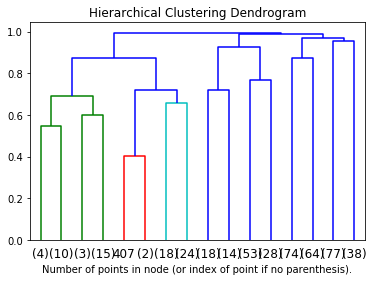

In [158]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(affinity = 'precomputed', n_clusters = None, linkage = 'complete', distance_threshold = 0).fit(sim)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

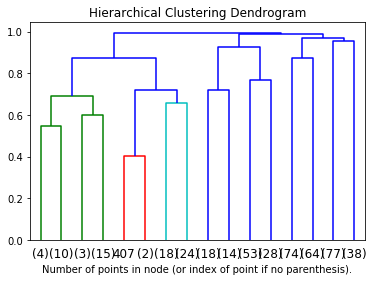

In [80]:
pd.DataFrame(set(df['ZIP_ODDAJE']) | set(df['ZIP_PREJEMA']))[0].apply(lambda x: x // 1000).reset_index().groupby(0).count()

,index
0,
-1,1
1,89
2,96
3,63
4,44
5,42
6,36
8,60
9,36


In [83]:
df.columns

Index(['MATIČNA_POŠILJATELJA', 'POSILJATELJ', 'STATUS_POSILJATELJA',
       'PREJEMNIK', 'MATIČNA_PREJEMNIKA', 'STATUS_PREJEMNIKA',
       'MATIČNA_PREVOZNIKA', 'PREVOZNIK', 'DAT_ODDAJA', 'KRAJ_ODDAJE',
       'LOKACIJA_ODDAJE', 'DAT_PREJEM_ZAV', 'KRAJ_PREJEMA', 'LOKACIJA_PREJEMA',
       'ŠTEVILKA', 'NAZIV_ODPADKA', 'NEVAREN', 'KOLIČINA ODPADKA v kg',
       'EMB_SHEMA', 'SVEČE PRI ODPADKU 20 02 03 D/N', 'DEJAVNOST_NAST',
       'IZVOR ODPADKA', 'PREDVIDEN POSTOPEK RAVNANJA', 'STATUS_EVL',
       'IND_SPREJETO', 'ZIP_ODDAJE', 'nXXX', 'nXXX_ODDAJE', 'ZIP_PREJEMA',
       'nXXX_PREJEMA'],
      dtype='object')

In [61]:
df['LOKACIJA_ODDAJE'].str.startswith('Brez').sum()

75224

In [38]:
xxx = xx.reset_index()
xxx['p'] = xxx['index'].apply(lambda x: x // 1000)
xxx.groupby('p').count()['LOKACIJA_ODDAJE']

p
-1     1
 1    89
 2    96
 3    63
 4    44
 5    42
 6    36
 8    60
 9    36
Name: LOKACIJA_ODDAJE, dtype: int64

In [13]:
df

,MATIČNA_POŠILJATELJA,POSILJATELJ,STATUS_POSILJATELJA,PREJEMNIK,MATIČNA_PREJEMNIKA,STATUS_PREJEMNIKA,MATIČNA_PREVOZNIKA,PREVOZNIK,DAT_ODDAJA,KRAJ_ODDAJE,...,NAZIV_ODPADKA,NEVAREN,KOLIČINA ODPADKA v kg,EMB_SHEMA,SVEČE PRI ODPADKU 20 02 03 D/N,DEJAVNOST_NAST,IZVOR ODPADKA,PREDVIDEN POSTOPEK RAVNANJA,STATUS_EVL,IND_SPREJETO
0,3854060000,A.B.C. AVTO CENTER d.o.o.,IZVIRNI POVZROCITELJ,KOMUNALA Komunalno podjetje Nova Gorica d.d.,5015812000,ZBIRALEC,5015812000,KOMUNALA Komunalno podjetje Nova Gorica d.d.,31.12.17,Sedež,...,Papirna in kartonska embalaža ter embalaža iz ...,NaN,72.0,NaN,NaN,PROIZVODNJA,NASTAJANJE KOMUNALNIH ODPADKOV,ZBIRANJE SPLOŠNO,PODPISAN_PREVZEMNIK,D
1,3854060000,A.B.C. AVTO CENTER d.o.o.,IZVIRNI POVZROCITELJ,KOMUNALA Komunalno podjetje Nova Gorica d.d.,5015812000,ZBIRALEC,5015812000,KOMUNALA Komunalno podjetje Nova Gorica d.d.,31.12.17,Sedež,...,Plastična embalaža,NaN,68.0,NaN,NaN,PROIZVODNJA,NASTAJANJE KOMUNALNIH ODPADKOV,ZBIRANJE SPLOŠNO,PODPISAN_PREVZEMNIK,D
2,5460450000,"ACORD-92, podjetje za finančne, tehnične in po...",IZVIRNI POVZROCITELJ,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,5432391000,PREDELOVALEC,5432391000,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,31.12.17,SEDEŽ,...,Papirna in kartonska embalaža ter embalaža iz ...,NaN,95.0,EMB UNIREC,NaN,PROIZVODNJA,NASTAJANJE NEKOMUNALNIH ODPADKOV,"R12, R13 Izmenjava odpadkov za predelavo s kat...",PODPISAN_PREVZEMNIK,D
3,5460450000,"ACORD-92, podjetje za finančne, tehnične in po...",IZVIRNI POVZROCITELJ,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,5432391000,PREDELOVALEC,5432391000,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,31.12.17,SEDEŽ,...,Papirna in kartonska embalaža ter embalaža iz ...,NaN,112.0,EMB UNIREC,NaN,PROIZVODNJA,NASTAJANJE NEKOMUNALNIH ODPADKOV,"R12, R13 Izmenjava odpadkov za predelavo s kat...",PODPISAN_PREVZEMNIK,D
4,5460450000,"ACORD-92, podjetje za finančne, tehnične in po...",IZVIRNI POVZROCITELJ,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,5432391000,PREDELOVALEC,5432391000,SAUBERMACHER SLOVENIJA storitve pri varstvu ok...,31.12.17,SEDEŽ,...,Papirna in kartonska embalaža ter embalaža iz ...,NaN,257.0,EMB UNIREC,NaN,PROIZVODNJA,NASTAJANJE NEKOMUNALNIH ODPADKOV,"R12, R13 Izmenjava odpadkov za predelavo s kat...",PODPISAN_PREVZEMNIK,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936022,8006903000,"1700, gostinske storitve, d.o.o.",IZVIRNI POVZROCITELJ,EKSTREM ČISTO d.o.o. ČISTILNI SERVIS,6199780000,ZBIRALEC,6199780000,EKSTREM ČISTO d.o.o. ČISTILNI SERVIS,01.01.21,SEDEŽ,...,Biorazgradljivi kuhinjski odpadki in odpadki i...,NaN,35.0,NaN,NaN,PROIZVODNJA,NASTAJANJE NEKOMUNALNIH ODPADKOV,ZBIRANJE SPLOŠNO,PODPISAN_PREVZEMNIK,D
2936023,8006903000,"1700, gostinske storitve, d.o.o.",IZVIRNI POVZROCITELJ,EKSTREM ČISTO d.o.o. ČISTILNI SERVIS,6199780000,ZBIRALEC,6199780000,EKSTREM ČISTO d.o.o. ČISTILNI SERVIS,01.01.21,SEDEŽ,...,Jedilno olje in masti,NaN,40.0,NaN,NaN,PROIZVODNJA,NASTAJANJE NEKOMUNALNIH ODPADKOV,ZBIRANJE SPLOŠNO,PODPISAN_PREVZEMNIK,D
2936024,1858220000,3CNC proizvodnja in trgovina d.o.o.,IZVIRNI POVZROCITELJ,"ODPAD, zbiranje in predelava sekundarnih surov...",5577772000,PREDELOVALEC,1858220000,3CNC proizvodnja in trgovina d.o.o.,01.01.21,Sedež in PE Neverke,...,Prah in delci železa,NaN,685.0,NaN,NaN,NaN,NASTAJANJE NEKOMUNALNIH ODPADKOV,"R12, R13 Izmenjava odpadkov za predelavo s kat...",PODPISAN_PREVZEMNIK,D
2936025,1858220000,3CNC proizvodnja in trgovina d.o.o.,IZVIRNI POVZROCITELJ,"ODPAD, zbiranje in predelava sekundarnih surov...",5577772000,PREDELOVALEC,5577772000,"ODPAD, zbiranje in predelava sekundarnih surov...",01.01.21,Sedež in PE Neverke,...,Opilki in ostružki železa,NaN,19220.0,NaN,NaN,NaN,NASTAJANJE NEKOMUNALNIH ODPADKOV,"R12, R13 Izmenjava odpadkov za predelavo s kat...",PODPISAN_PREVZEMNIK,D


In [13]:
df.columns

Index(['MATIČNA_POŠILJATELJA', 'POSILJATELJ', 'STATUS_POSILJATELJA',
       'PREJEMNIK', 'MATIČNA_PREJEMNIKA', 'STATUS_PREJEMNIKA',
       'MATIČNA_PREVOZNIKA', 'PREVOZNIK', 'DAT_ODDAJA', 'KRAJ_ODDAJE',
       'LOKACIJA_ODDAJE', 'DAT_PREJEM_ZAV', 'KRAJ_PREJEMA', 'LOKACIJA_PREJEMA',
       'ŠTEVILKA', 'NAZIV_ODPADKA', 'NEVAREN', 'KOLIČINA ODPADKA v kg',
       'EMB_SHEMA', 'SVEČE PRI ODPADKU 20 02 03 D/N', 'DEJAVNOST_NAST',
       'IZVOR ODPADKA', 'PREDVIDEN POSTOPEK RAVNANJA', 'STATUS_EVL',
       'IND_SPREJETO'],
      dtype='object')

In [15]:
df['STATUS_POSILJATELJA'].value_counts()

IZVIRNI POVZROCITELJ    595926
ZBIRALEC                 36004
PREDELOVALEC             18222
ODSTRANJEVALEC            1343
Name: STATUS_POSILJATELJA, dtype: int64

In [17]:
df['DEJAVNOST_NAST'].value_counts()

PROIZVODNJA      578092
KOMUNALA          33448
GOSPODINJSTVA     16812
Name: DEJAVNOST_NAST, dtype: int64

In [19]:
df['STATUS_EVL'].value_counts()

PODPISAN_PREVZEMNIK     649829
V_DELU_PREV_POSILJ         792
PODPISAN_POSILJATELJ       503
V_DELU_PREVZEMNIK          208
V_DELU_POSILJATELJ         163
Name: STATUS_EVL, dtype: int64

In [21]:
df['IND_SPREJETO'].value_counts()

D    650305
N       448
Name: IND_SPREJETO, dtype: int64